In [ ]:
########################################################################
## This file builds the dissimilarity matrices from one week of data
## Required files: 'locations.csv' and '2021_04_01_week_associations_times.csv'
## Produces files:
##                - 'ds_mat_b_avg.csv'
##                - 'ds_mat_b_min.csv'
##                - 'ds_mat_b_avg_scaled.csv'
##                - 'ds_mat_b_min_scaled.csv'
##                - 'ds_mat_ap_avg.csv'
##                - 'ds_mat_ap_min.csv'
##                - 'ds_mat_ap_avg_scaled.csv'
##                - 'ds_mat_ap_min_scaled.csv'
## NOTE: USE ONLY SUBSET FOR ACCESS POINT TO ACCESS POINT MATRIX
########################################################################

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import sys
from numpy import inf

In [2]:
# IMPORT DATA

In [3]:
# import associations data generated from DataPreprocessing_2021_04_01_week notebook
# schema: ap_1, ap_2, total_time, frequency, min_time
week_associations_times_df = pd.read_csv('2021_04_01_week_associations_times.csv')
week_associations_times_df

,ap_1,ap_2,total_time,frequency,min_time
0,1106,412028,1150.462876,1,1150.462876
1,1106,412046,8666.911970,2,4332.140609
2,1106,412126,15732.078110,4,3565.275391
3,1106,412130,22974.635946,6,3524.078823
4,1106,412135,1147.993553,1,1147.993553
...,...,...,...,...,...
16528277,424298,424291,36051.810511,9,3015.520140
16528278,424298,424293,2147.377507,6,31.433817
16528279,424298,424295,29788.171607,12,254.751505
16528280,424298,424296,11942.503216,3,3600.144133


In [4]:
# import locations information
# schema: installation_id, name, latitude, longitude, accuracy
locations_df = pd.read_csv('locations.csv')
locations_df

,installation_id,name,latitude,longitude,accuracy
0,419351,1220cc-122-1,43.069064,-89.406687,20
1,418533,1220cc-125-1,43.068890,-89.406787,20
2,419142,1220cc-140-1,43.068924,-89.406417,20
3,418868,1220cc-144-1,43.069336,-89.406421,34
4,419098,1220cc-165-1,43.069081,-89.406393,20
...,...,...,...,...,...
10992,415857,zoo-443-1,43.071706,-89.405150,30
10993,416868,zoo-449-1,43.071860,-89.405114,30
10994,415838,zoo-455-1,43.071739,-89.405175,20
10995,415915,zoo-461-1,43.072012,-89.405152,30


In [5]:
# SET UP

In [6]:
# map of installation_id (key) to building name (value)
id_name = {}
# list of all the buildings
building_names = [] 

prev_name = None
for i, row in locations_df.iterrows():
    # get current name and current installation id
    curr_name = row['name'].split('-')[0]
    curr_id = row['installation_id']
    
    # get unique building names
    if prev_name == None:
        prev_name = curr_name
    elif prev_name != curr_name:
        building_names.append(prev_name)
        prev_name = curr_name
    
    # access point --> buildings (that the access point is in)
    if curr_id not in id_name:
        id_name[curr_id] = curr_name
        
building_names.append(curr_name)

# store number of buildings
n_buildings = len(building_names)

In [37]:
# BUILDINGS
# buildings DS matrices will be n_buildings x n_buildings
# where n_buildings is the number of buildings

In [32]:
# generate mappings to make look ups when buidling Buildings ds matrices faster

# map of building name (key) to index (between 0 and number of unique buildings) (value)
name_index = {}
# map of index (key) to building name (value)
index_name = {}

for i in range(n_buildings):
    name_index[building_names[i]] = i
    index_name[i] = building_names[i]

In [33]:
# track total frequency
buildings_N = 0

# track building frequency
buildings_df = np.zeros((n_buildings,))

# track association frequency
buildings_tf = np.zeros((n_buildings,n_buildings))

In [34]:
################################################################################
## Build Dissimilarity Matrix B_avg: 
# Pairwise distance of buildings using average time apart and no scaling
################################################################################

ds_mat_b_sum = np.zeros((n_buildings,n_buildings))
ds_mat_b_freq = np.zeros((n_buildings,n_buildings))
#ds_mat_b_avg = np.zeros((n_buildings,n_buildings))

# fill ds matrix
for i, row in week_associations_times_df.iterrows():
    if row['ap_1'] in id_name and row['ap_2'] in id_name: # handles any errors in the ids
        name1 = id_name[row['ap_1']]
        name2 = id_name[row['ap_2']]
        if name1 != name2:
            index1 = name_index[name1]
            index2 = name_index[name2]
            
            # update ds mat sum and frequency
            ds_mat_b_sum[index1][index2] += row['total_time']
            ds_mat_b_sum[index2][index1] += row['total_time']
            ds_mat_b_freq[index1][index2] += row['frequency']
            ds_mat_b_freq[index2][index1] += row['frequency']


# calculate avg for ds mat
ds_mat_b_avg = np.divide(ds_mat_b_sum, ds_mat_b_freq)

# catch and fix overflow errors
ds_mat_b_avg[np.isnan(ds_mat_b_avg)] = 0

# export to csv
np.savetxt('ds_mat_b_avg.csv', ds_mat_b_avg, delimiter=',', fmt='%d')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


array([[   0.        ,    0.        , 2982.77303707, ..., 5952.310018  ,
        3282.16101761,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [2982.77303707,    0.        ,    0.        , ..., 2794.30090753,
        1544.27690839,    0.        ],
       ...,
       [5952.310018  ,    0.        , 2794.30090753, ...,    0.        ,
        3368.10203384,    0.        ],
       [3282.16101761,    0.        , 1544.27690839, ..., 3368.10203384,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

In [45]:
################################################################################
## Build Dissimilarity Matrix B_min: 
# Pairwise distance of buildings using minimum time apart and no scaling
################################################################################
ds_mat_b_min = np.zeros((n_buildings,n_buildings))

# fill ds matrix
for i, row in week_associations_times_df.iterrows():
    if row['ap_1'] in id_name and row['ap_2'] in id_name: # handles any errors in the ids
        name1 = id_name[row['ap_1']]
        name2 = id_name[row['ap_2']]
        if name1 != name2:
            index1 = name_index[name1]
            index2 = name_index[name2]
            
            if (ds_mat_b_min[index1][index2] == 0) or (row['min_time'] < ds_mat_b_min[index1][index2]):
                ds_mat_b_min[index1][index2] = row['min_time']
                ds_mat_b_min[index2][index1] = row['min_time']
                
# export to csv
np.savetxt('ds_mat_b_min.csv', ds_mat_b_min, delimiter=',', fmt='%d')    

In [40]:
####################################
# calculate how to scale the values
####################################

# building frequency scaling
# scaling by a version of tfidf
# tf = term frequency (number of times the connection between building a, b appears)
# idf = inverse document frequency = log(N/df)
# N = total number of connections between all buildings
# df = document frequency (sum of freq of union of connections that building a and building b each have)

# track total frequency
buildings_N = sum(sum(ds_mat_b_freq))

# track building frequency
buildings_df = ds_mat_b_freq.sum(axis=0)

# track association frequency
# ds_mat_b_freq is tf

buildings_tfidf = np.zeros((n_buildings,n_buildings))

# calculate tfidf
for i in range(n_buildings):
    for j in range(i+1,n_buildings):
        if (i != j) and (ds_mat_b_avg[i][j] != 0) and ((buildings_df[i] + buildings_df[j] - ds_mat_b_freq[i][j]) != 0):
            buildings_tfidf[i][j] = ds_mat_b_freq[i][j] * np.log(buildings_N/(buildings_df[i] + buildings_df[j] - ds_mat_b_freq[i][j]))

# catch divide by zero problems
buildings_tfidf[buildings_tfidf == inf] = 0  

In [41]:
################################################################################
## Build Dissimilarity Matrix B_avg_scaled: 
# Pairwise distance of buildings using average time apart with frequency scaling
################################################################################
ds_mat_b_avg_scaled = np.zeros((n_buildings,n_buildings))
for i in range(n_buildings):
    for j in range(i+1,n_buildings):
        if (i != j):
            ds_mat_b_avg_scaled[i][j] = ds_mat_b_avg_scaled[j][i] = buildings_tfidf[i][j] * ds_mat_b_avg[i][j]
            
# export to csv
np.savetxt('ds_mat_b_avg_scaled.csv', ds_mat_b_avg_scaled, delimiter=',', fmt='%d')

In [46]:
################################################################################
## Build Dissimilarity Matrix B_min_scaled: 
# Pairwise distance of buildings using minimum time apart with frequency scaling
################################################################################
ds_mat_b_min_scaled = np.zeros((n_buildings,n_buildings))
for i in range(n_buildings):
    for j in range(i+1,n_buildings):
        if (i != j):
            ds_mat_b_min_scaled[i][j] = ds_mat_b_min_scaled[j][i] = buildings_tfidf[i][j] * ds_mat_b_min[i][j]
            
# export to csv
np.savetxt('ds_mat_b_min_scaled.csv', ds_mat_b_min_scaled, delimiter=',', fmt='%d')

In [43]:
####################################
# save labels for ds building mat
####################################
np.savetxt("ds_mat_labels_b.csv", building_names, delimiter=',', fmt='%s')

In [ ]:
####################################
# get subset
####################################

In [170]:
count_associations

array([139,   0, 161, 158,   0, 157, 154, 101, 143, 162, 157, 160,   0,
       150, 106,   0, 153, 110,  85,   0,   0,   0,   0, 159,   0, 159,
       162, 162, 154, 157, 158, 154,   0,   0,   0,   0, 154, 160, 156,
       157, 154, 155, 159,   0, 155, 159, 162, 155, 162, 153, 119, 161,
       154, 163, 153,   0, 150, 157,  41, 160, 154, 158, 160, 154, 154,
       159, 163, 139, 160, 163,   0, 157,   0, 156, 153, 158,   0, 161,
       157, 161, 161, 152, 157,   0, 162, 158, 139, 128, 160, 151, 139,
       160, 158, 163, 161, 153, 157, 156, 149, 161,   0, 157,   5,   0,
       156,   0, 155, 160, 137, 147, 145, 151, 158,   0, 155, 163, 162,
       161, 153, 141, 161, 161, 157, 157, 161, 152, 161, 158, 154, 150,
       161, 157,   0, 154,   0,   0, 155,   2, 155, 157, 160, 156, 157,
       128,  80,  20, 156, 154, 160, 141, 101,   0,  47, 162, 154, 156,
         0, 161, 163, 159,   0, 162, 158, 158, 151, 160,   0,   0, 154,
       161, 160, 157,   0, 152,   0, 148, 160, 113,   0, 153, 15

In [171]:
count_associations = (ds_mat_b_freq != 0).sum(0) 

b_subset_indices = []
b_subset_labels = []
subset_size = 0

for i in range(n_buildings):
    if count_associations[i] > 0: #np.mean(count_associations):#[count_associations != 0]):
        b_subset_indices.append(i)
        b_subset_labels.append(index_name[i])
        subset_size += 1

In [196]:
# set up for scaling
# track total frequency
b_subset_N = 0

# track building frequency
b_subset_df = np.zeros((subset_size,))

# track association frequency
b_subset_tf = np.zeros((subset_size,subset_size))

b_subset_tfidf = np.zeros((subset_size,subset_size))

for i in range(subset_size):
    for j in range(i+1,subset_size):
        index1 = b_subset_indices[i]
        index2 = b_subset_indices[j]
        # update N
        b_subset_N += ds_mat_b_freq[index1][index2]
        
        # update df
        b_subset_df[i] += ds_mat_b_freq[index1][index2]
        b_subset_df[j] += ds_mat_b_freq[index1][index2]
        
        # update tf
        b_subset_tf[i][j] += ds_mat_b_freq[index1][index2]
        b_subset_tf[j][i] += ds_mat_b_freq[index1][index2]

# calculate tfidf
# calculate tfidf
for i in range(subset_size):
    for j in range(i+1,subset_size):
        if ((b_subset_df[i] + b_subset_df[j]) != 0) and (b_subset_tf[i][j] != 0):
            tf = b_subset_tf[i][j]
            bool_tf = max(0, b_subset_tf[i][j]/b_subset_tf[i][j])
            log_tf = 1 + np.log(b_subset_tf[i][j])
            aug_tf = 0.5 + 0.5*np.log(b_subset_tf[i][j])/b_subset_tf.max()
            log_avg_tf = (1 + np.log(b_subset_tf[i][j]))/(1 + np.log(np.mean(b_subset_tf)))
            idf = np.log(1 + (b_subset_N/(b_subset_df[i] + b_subset_df[j] - b_subset_tf[i][j])))
            prob_idf = max(0, np.log((b_subset_N - b_subset_df[i] - b_subset_df[j] + b_subset_tf[i][j])/(b_subset_df[i] + b_subset_df[j] - b_subset_tf[i][j])))
            b_subset_tfidf[i][j] = bool_tf * idf
            #b_subset_tfidf[i][j] = b_subset_tf[i][j] * np.log(b_subset_N/(b_subset_df[i] + b_subset_df[j] - b_subset_tf[i][j]))

# catch divide by zero problems
b_subset_tfidf[b_subset_tfidf == inf] = 0 

In [197]:
ds_mat_b_min_subset = np.zeros((subset_size,subset_size))
ds_mat_b_avg_subset = np.zeros((subset_size,subset_size))

for i in range(subset_size):
    for j in range(i+1,subset_size):
        index1 = b_subset_indices[i]
        index2 = b_subset_indices[j]
        ds_mat_b_min_subset[i][j] = ds_mat_b_min_subset[j][i] = b_subset_tfidf[i][j] * ds_mat_b_min[index1][index2]
        ds_mat_b_avg_subset[i][j] = ds_mat_b_avg_subset[j][i] = b_subset_tfidf[i][j] * ds_mat_b_avg[index1][index2]

In [198]:
# export to csv
np.savetxt('ds_mat_b_min_subset.csv', ds_mat_b_min_subset, delimiter=',', fmt='%d')
np.savetxt('ds_mat_b_avg_subset.csv', ds_mat_b_avg_subset, delimiter=',', fmt='%d')

# save subset labels
np.savetxt("ds_mat_b_subset.csv", b_subset_labels, delimiter=',', fmt='%s')

In [117]:
np.mean(count_associations)

119.64251207729468

In [118]:
np.std(count_associations)

63.639593071058

In [121]:
np.mean(count_associations[count_associations != 0])

148.2994011976048

In [126]:
(ds_mat_b_min_scaled_subset == 0).sum(0)

array([1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

(array([40.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  4.,  0.,  2.,  0.,
         1.,  0.,  1.,  0.,  1.,  1.,  1.,  4.,  3.,  3.,  7., 15.,  7.,
         9., 18., 11.,  7., 16., 17., 11.,  9.]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
 

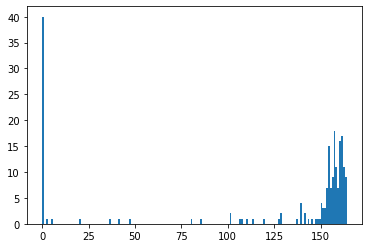

In [116]:
plt.hist(count_associations, bins=np.arange(count_associations.min(), count_associations.max()+1))

[18  1  1  3  2 11  1  2  2  5  4  1  1  1  1  3  2  1  2  1  1  3  1  4
  3  1  3  1  1  3  1  2  1  2  1  3  4  4  1  5  1  1  1  2  1  1 13  1
  1  1  1  7  2  1  2  1  1  2  1  1  2 13 28  1  3 13  1  2  1  1  2  1
  2  5  1  2  2  1  1 15  6  8  3  1  2  1  1  1  1 15  1  1  1  1  1  5
  1  2  2  4  2  2  1  2  3  2  1  2  1 24  1  2  1 14  1  2  2  1  1  2
  1  1  1  2  1  1  1  1  1  4  9  1  3  6  2 25  1  1  1  3  2  1  1  3
  1  1  2  1  1  1  1  1]


[ 68 207  46  49 207  50  53 106  64  45  50  47 207  57 101 207  54  97
 122 207 207 207 207  48 207  48  45  45  53  50  49  53 207 207 207 207
  53  47  51  50  53  52  48 207  52  48  45  52  45  54  88  46  53  44
  54 207  57  50 166  47  53  49  47  53  53  48  44  68  47  44 207  50
 207  51  54  49 207  46  50  46  46  55  50 207  45  49  68  79  47  56
  68  47  49  44  46  54  50  51  58  46 207  50 202 207  51 207  52  47
  70  60  62  56  49 207  52  44  45  46  54  66  46  46  50  50  46  55
  46  49  53  57  46  50 207  53 207 207  52 205  52  50  47  51  50  79
 127 187  51  53  47  66 106 207 160  45  53  51 207  46  44  48 207  45
  49  49  56  47 207 207  53  46  47  50 207  55 207  59  47  94 207  54
  51 207  53 171 207  80  44  48  47  57  50  45 207 100  47  50  46 207
  46  51  45  47  43 207  49  44 207]


In [44]:
# ACCESS POINTS
# buildings DS matrices will be n_access_points x n_access_points
# where n_access_points is the number of access points

In [59]:
# generate mappings to make look ups when buidling Access Point ds matrices faster

# map of installation_id (key) to index (between 0 and number of unique access points) (value)
id_index = {}
# map of index (key) to installation_id (value)
index_id = {}

# count of access points
n_aps = 0

for i, row in locations_df.iterrows():
    id_index[row['installation_id']] = i
    index_id[i] = [row['installation_id']]
    n_aps += 1

In [48]:
# save buildings associated with each index for 

In [51]:
# track total frequency
ap_N = 0

# track building frequency
ap_df = np.zeros((n_aps,))

# track association frequency
ap_tf = np.zeros((n_aps,n_aps))

In [52]:
################################################################################
## Build Dissimilarity Matrix AP_avg: 
# Pairwise distance of access points using average time apart and no scaling
################################################################################
ds_mat_ap_avg = np.zeros((n_aps,n_aps))

# fill ds matrix
for i, row in week_associations_times_df.iterrows():
    if row['ap_1'] in id_name and row['ap_2'] in id_name: # handles any errors in the ids
        index1 = id_index[row['ap_1']]
        index2 = id_index[row['ap_2']]
            
        # update ds mat 
        if ds_mat_ap_avg[index1][index2] == 0:
            ds_mat_ap_avg[index1][index2] += row['total_time'] / row['frequency']
            ds_mat_ap_avg[index2][index1] += row['total_time'] / row['frequency']
            
            # update records for scaling
            ap_N += row['frequency']
            ap_df[index1] += row['frequency']
            ap_df[index2] += row['frequency']
            ap_tf[index1][index2] = row['frequency']
            ap_tf[index2][index1] = row['frequency']
        

# export to csv
np.savetxt('ds_mat_ap_avg.csv', ds_mat_ap_avg, delimiter=',', fmt='%d')

In [53]:
################################################################################
## Build Dissimilarity Matrix AP_min: 
# Pairwise distance of access points using min time apart and no scaling
################################################################################
ds_mat_ap_min = np.zeros((n_aps,n_aps))

# fill ds matrix
for i, row in week_associations_times_df.iterrows():
    if row['ap_1'] in id_name and row['ap_2'] in id_name: # handles any errors in the ids
        index1 = id_index[row['ap_1']]
        index2 = id_index[row['ap_2']]\
            
        if (ds_mat_ap_min[index1][index2] == 0) or (row['min_time'] < ds_mat_ap_min[index1][index2]):
            ds_mat_ap_min[index1][index2] = row['min_time']
            ds_mat_ap_min[index2][index1] = row['min_time']
                
# export to csv
np.savetxt('ds_mat_ap_min.csv', ds_mat_ap_min, delimiter=',', fmt='%d')  

In [54]:
####################################
# calculate how to scale the values
####################################
ap_tfidf = np.zeros((n_aps,n_aps))

# calculate tfidf
for i in range(n_aps):
    for j in range(i+1,n_aps):
        if (i != j) and (ds_mat_ap_avg[i][j] != 0) and ((ap_df[i] + ap_df[j] - ap_tf[i][j]) != 0):
            ap_tfidf[i][j] = ap_tf[i][j] * np.log(ap_N/(ap_df[i] + ap_df[j] - ap_tf[i][j]))

# catch divide by zero problems
ap_tfidf[ap_tfidf == inf] = 0 

In [55]:
################################################################################
## Build Dissimilarity Matrix AP_avg_scaled: 
# Pairwise distance of access points using average time apart with frequency scaling
################################################################################
ds_mat_ap_avg_scaled = np.zeros((n_aps,n_aps))

for i in range(n_aps):
    for j in range(i+1,n_aps):
        if (i != j):
            ds_mat_ap_avg_scaled[i][j] = ds_mat_ap_avg_scaled[j][i] = ap_tfidf[i][j] * ds_mat_ap_avg[i][j]
            
# export to csv
np.savetxt('ds_mat_ap_avg_scaled.csv', ds_mat_ap_avg_scaled, delimiter=',', fmt='%d')

In [56]:
################################################################################
## Build Dissimilarity Matrix AP_min_scaled: 
# Pairwise distance of access points using min time apart with frequency scaling
################################################################################
ds_mat_ap_min_scaled = np.zeros((n_aps,n_aps))

for i in range(n_aps):
    for j in range(i+1,n_aps):
        if (i != j):
            ds_mat_ap_min_scaled[i][j] = ds_mat_ap_min_scaled[j][i] = ap_tfidf[i][j] * ds_mat_ap_min[i][j]
            
# export to csv
np.savetxt('ds_mat_ap_min_scaled.csv', ds_mat_ap_min_scaled, delimiter=',', fmt='%d')

In [84]:
# get subset of access points with enough data
num_associations = (ap_tf != 0).sum(0)     

ds_mat_ap_subset_indices = []
ds_mat_ap_subset_ids = []
ds_mat_ap_subset_labels = []

count = 0

for i in range(n_aps):
    if num_associations[i] >= (np.mean(num_associations)):
        count += 1
        ds_mat_ap_subset_indices.append(i)
        ds_mat_ap_subset_ids.append(index_id[i])
        ds_mat_ap_subset_labels.append(id_name[index_id[i][0]])

ds_mat_ap_min_scaled_subset = np.zeros((count,count))
        
for i in range(count):
    for j in range(i+1, count):
        index1 = ds_mat_ap_subset_indices[i]
        index2 = ds_mat_ap_subset_indices[j]
        ds_mat_ap_min_scaled_subset[i][j] = ds_mat_ap_min_scaled_subset[j][i] = ds_mat_ap_min_scaled[index1][index2]

# export to csv
np.savetxt('ds_mat_ap_min_scaled_subset.csv', ds_mat_ap_min_scaled_subset, delimiter=',', fmt='%d')

# save subset labels
np.savetxt("ds_mat_ap_subset_labels.csv", ds_mat_ap_subset_labels, delimiter=',', fmt='%s')

array([[     0.        ,      0.        ,  50607.38694466, ...,
         34896.35736843,  19451.99216959,  73287.04973147],
       [     0.        ,      0.        ,    916.56644149, ...,
         31080.13425742,  29970.39746394,  39135.37016008],
       [ 50607.38694466,    916.56644149,      0.        , ...,
        110455.06309047,  79606.528541  ,  16389.52629018],
       ...,
       [ 34896.35736843,  31080.13425742, 110455.06309047, ...,
             0.        ,   1007.38015348,   1889.03022077],
       [ 19451.99216959,  29970.39746394,  79606.528541  , ...,
          1007.38015348,      0.        ,    564.82401915],
       [ 73287.04973147,  39135.37016008,  16389.52629018, ...,
          1889.03022077,    564.82401915,      0.        ]])

In [90]:
num_outside_associations = np.zeros((n_aps))
for i in range(n_aps):
    curr_name = id_name[index_id[i][0]]
    for j in range(n_aps):
        check_name = id_name[index_id[j][0]]
        if (curr_name != check_name) and (ap_tf[i][j] != 0):
            num_outside_associations[i] += 1
print(num_outside_associations)
print(min(num_outside_associations))
print(max(num_outside_associations))

[  0.   0. 246. ...   0.   0.   0.]
0.0
8328.0


In [91]:
print(np.mean(num_outside_associations))

1105.9190688369556


In [95]:
# get subset of access points with enough data   

ds_mat_ap_subset2_indices = []
ds_mat_ap_subset2_ids = []
ds_mat_ap_subset2_labels = []

count2 = 0

for i in range(n_aps):
    if num_outside_associations[i] >= (np.mean(num_outside_associations) + np.std(num_outside_associations)):
        count2 += 1
        ds_mat_ap_subset2_indices.append(i)
        ds_mat_ap_subset2_ids.append(index_id[i])
        ds_mat_ap_subset2_labels.append(id_name[index_id[i][0]])

ds_mat_ap_min_scaled_subset2 = np.zeros((count,count))
        
for i in range(count2):
    for j in range(i+1, count2):
        index1 = ds_mat_ap_subset2_indices[i]
        index2 = ds_mat_ap_subset2_indices[j]
        ds_mat_ap_min_scaled_subset2[i][j] = ds_mat_ap_min_scaled_subset2[j][i] = ds_mat_ap_min_scaled[index1][index2]

# export to csv
np.savetxt('ds_mat_ap_min_scaled_subset2.csv', ds_mat_ap_min_scaled_subset2, delimiter=',', fmt='%d')

# save subset labels
np.savetxt("ds_mat_ap_subset2_labels.csv", ds_mat_ap_subset2_labels, delimiter=',', fmt='%s')

In [96]:
# get subset using min for ones in same building and average for diff buildings
# get subset of access points with enough data   

ds_mat_ap_subset3 = np.zeros((count,count))
        
for i in range(count2):
    for j in range(i+1, count2):
        index1 = ds_mat_ap_subset2_indices[i]
        index2 = ds_mat_ap_subset2_indices[j]
        name1 = ds_mat_ap_subset2_labels[i]
        name2 = ds_mat_ap_subset2_labels[j]
        if name1 == name2:
            ds_mat_ap_subset3[i][j] = ds_mat_ap_subset3[j][i] = ds_mat_ap_min[index1][index2]
        else:
            ds_mat_ap_subset3[i][j] = ds_mat_ap_subset3[j][i] = ds_mat_ap_avg[index1][index2]
        

# export to csv
np.savetxt('ds_mat_ap_subset3.csv', ds_mat_ap_subset3, delimiter=',', fmt='%d')

# save subset labels
np.savetxt("ds_mat_ap_subset3_labels.csv", ds_mat_ap_subset2_labels, delimiter=',', fmt='%s')

In [104]:
# get subset using min for ones in same building and average for diff buildings
# get subset of access points with enough data   

ds_mat_ap_subset4 = np.zeros((count,count))
        
for i in range(count2):
    for j in range(i+1, count2):
        index1 = ds_mat_ap_subset2_indices[i]
        index2 = ds_mat_ap_subset2_indices[j]
        name1 = ds_mat_ap_subset2_labels[i]
        name2 = ds_mat_ap_subset2_labels[j]
        if name1 == name2:
            ds_mat_ap_subset4[i][j] = ds_mat_ap_subset4[j][i] = (ap_tf[index1][index2]/n_aps) *ds_mat_ap_min[index1][index2]
        else:
            ds_mat_ap_subset4[i][j] = ds_mat_ap_subset4[j][i] = ds_mat_ap_avg[index1][index2]
        

# export to csv
np.savetxt('ds_mat_ap_subset4.csv', ds_mat_ap_subset4, delimiter=',', fmt='%d')

In [ ]:
# get subset using min for ones in same building and average for diff buildings
# get subset of access points with enough data   

ds_mat_ap_subset5 = np.zeros((count,count))
        
for i in range(count2):
    for j in range(i+1, count2):
        index1 = ds_mat_ap_subset2_indices[i]
        index2 = ds_mat_ap_subset2_indices[j]
        name1 = ds_mat_ap_subset2_labels[i]
        name2 = ds_mat_ap_subset2_labels[j]
        if name1 == name2:
            ds_mat_ap_subset5[i][j] = ds_mat_ap_subset5[j][i] = (ap_tf[index1][index2]/n_aps) * ds_mat_ap_min[index1][index2]
        else:
            ds_mat_ap_subset5[i][j] = ds_mat_ap_subset5[j][i] = ((ap_df[index1] + ap_df[index2])/n_aps) * ds_mat_ap_avg[index1][index2]
        

# export to csv
np.savetxt('ds_mat_ap_subset4.csv', ds_mat_ap_subset4, delimiter=',', fmt='%d')

In [103]:
print(sum(sum(ds_mat_ap_min)))
print(max(ds_mat_ap_min))

21186052540.404846


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [66]:
####################################
# save labels for ds mat ap
####################################
ap_names = []
for i in range(n_aps):
    ap_names.append(id_name[index_id[i][0]])
   

np.savetxt("ds_mat_labels_ap.csv", ap_names, delimiter=',', fmt='%s')